In [29]:
import sys
sys.path.append('../../')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import keras
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dense, Input 
from tensorflow.keras.optimizers import Adam 

from utils.processing.v02.dataset import TradingDataset

In [30]:
SEQUENCE_LENGTH = 9
PREDICTION_LENGTH = 5
SHIFT_SIZE = 3
BATCH_SIZE = 32

# Loading the Dataframe

In [ ]:
df = pd.read_csv('../../pred_data.csv')
df.tail()

,DATETIME,OPEN,HIGH,LOW,CLOSE,VOLUME,EMA,RSI,MACD,SIGNAL_LINE,UPPER_BAND,LOWER_BAND,BOLLINGER_PERCENT_B,ATR
14995,2025-04-02 06:00:00,1.07939,1.07995,1.07931,1.07953,1324,1.07952,47.06,-0.00042,-0.00054,1.07955,1.08137,1.00989,0.00110
14996,2025-04-02 07:00:00,1.07952,1.07970,1.07920,1.07922,1040,1.07948,44.94,-0.00041,-0.00051,1.07943,1.08096,1.13332,0.00093
14997,2025-04-02 08:00:00,1.07921,1.07921,1.07856,1.07890,1673,1.07940,42.80,-0.00042,-0.00049,1.07929,1.08043,1.33690,0.00088
14998,2025-04-02 09:00:00,1.07890,1.07958,1.07869,1.07923,2821,1.07938,45.68,-0.00040,-0.00047,1.07926,1.08038,1.02498,0.00087
14999,2025-04-02 10:00:00,1.07921,1.07942,1.07889,1.07902,722,1.07933,44.15,-0.00040,-0.00045,1.07931,1.08029,1.29140,0.00081


In [32]:
ts = df.copy()
ts['DATETIME'] = pd.to_datetime(ts['DATETIME'])
ts = ts.set_index('DATETIME')
ts.sort_index(inplace=True)
ts = ts.loc['2024-05-01 00:00:00':]
ts = ts[:-20]
print(ts.shape)
ts.tail()

(5687, 13)


,OPEN,HIGH,LOW,CLOSE,VOLUME,EMA,RSI,MACD,SIGNAL_LINE,UPPER_BAND,LOWER_BAND,BOLLINGER_PERCENT_B,ATR
DATETIME,,,,,,,,,,,,,
2025-04-01 10:00:00,1.08077,1.08120,1.07987,1.08013,4265,1.08146,39.98,-0.00010,0.00010,1.08131,1.08306,1.67373,0.00091
2025-04-01 11:00:00,1.08010,1.08174,1.08000,1.08168,3097,1.08149,51.00,-0.00007,0.00009,1.08138,1.08308,0.82279,0.00095
2025-04-01 12:00:00,1.08168,1.08288,1.08143,1.08170,3072,1.08152,51.12,-0.00005,0.00007,1.08143,1.08311,0.83684,0.00100
2025-04-01 13:00:00,1.08169,1.08181,1.07897,1.07977,4102,1.08128,40.43,-0.00018,0.00004,1.08141,1.08315,1.93864,0.00114
2025-04-01 14:00:00,1.07976,1.07980,1.07779,1.07805,4088,1.08085,33.67,-0.00042,-0.00002,1.08134,1.08345,2.56203,0.00124


# Feature Engineering

### Créations des colonnes avec les valeurs prix de cloture décalées de 24h __Xi = (X[t - i])__

In [33]:
dataset = TradingDataset(ts, shift_size=SHIFT_SIZE, sequence_length=SEQUENCE_LENGTH)
dataset.prepare_data()

# Préparation des données de modélisation

In [34]:
X, y = dataset.feature_sequence, dataset.target_sequence

In [35]:
X, y = np.array(X), np.array(y)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

### Compilation du modèle

In [45]:
lstm_model = Sequential([
    Input(shape=(X.shape[1], X.shape[2])),    
    LSTM(128, return_sequences=True),
    LSTM(256),
    # Dense(8, activation='relu'),
    Dense(3, activation='linear')
])

lstm_model.compile(
    optimizer=Adam(learning_rate=0.00001, weight_decay = 1e-5),
    loss='mse'
)
lstm_model.summary()


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_6 (LSTM)                   │ (None, 9, 128)         │        86,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_7 (LSTM)                   │ (None, 256)            │       394,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 3)              │           771 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481,539 (1.84 MB)

 Trainable params: 481,539 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

### Apprentissage

In [46]:
# Entraînement du modèle
history = lstm_model.fit(
    X_train, 
    y_train, 
    batch_size=BATCH_SIZE, 
    epochs=100, 
    validation_data=(X_test, y_test), 
    verbose=1)

Epoch 1/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 44ms/step - loss: 0.3262 - val_loss: 0.0131
Epoch 2/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 40ms/step - loss: 0.0178 - val_loss: 0.0059
Epoch 3/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0029 - val_loss: 0.0028
Epoch 4/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 0.0015 - val_loss: 0.0016
Epoch 5/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 8.8403e-04 - val_loss: 0.0011
Epoch 6/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 6.4310e-04 - val_loss: 0.0010
Epoch 7/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 6s 39ms/step - loss: 5.5483e-04 - val_loss: 9.1805e-04
Epoch 8/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - loss: 5.6087e-04 - val_loss: 8.6629e-04
Epoch 9/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 5.0662e-04 - val_loss: 8.3433e-04
Epoch 10/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 4.8429e-04 - val_loss: 8.0158e-04
Epoch 11/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 5s 36ms/step - loss: 4.7716e-04 - v

## Evaluation du modèle

### Courbe d'apprentissage

36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


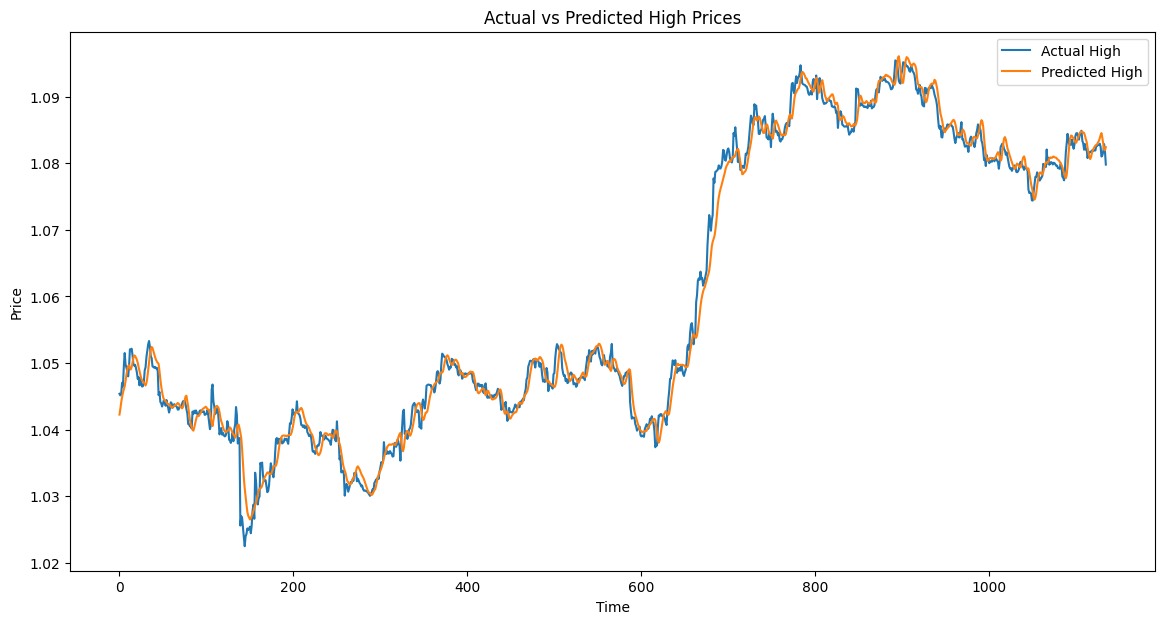

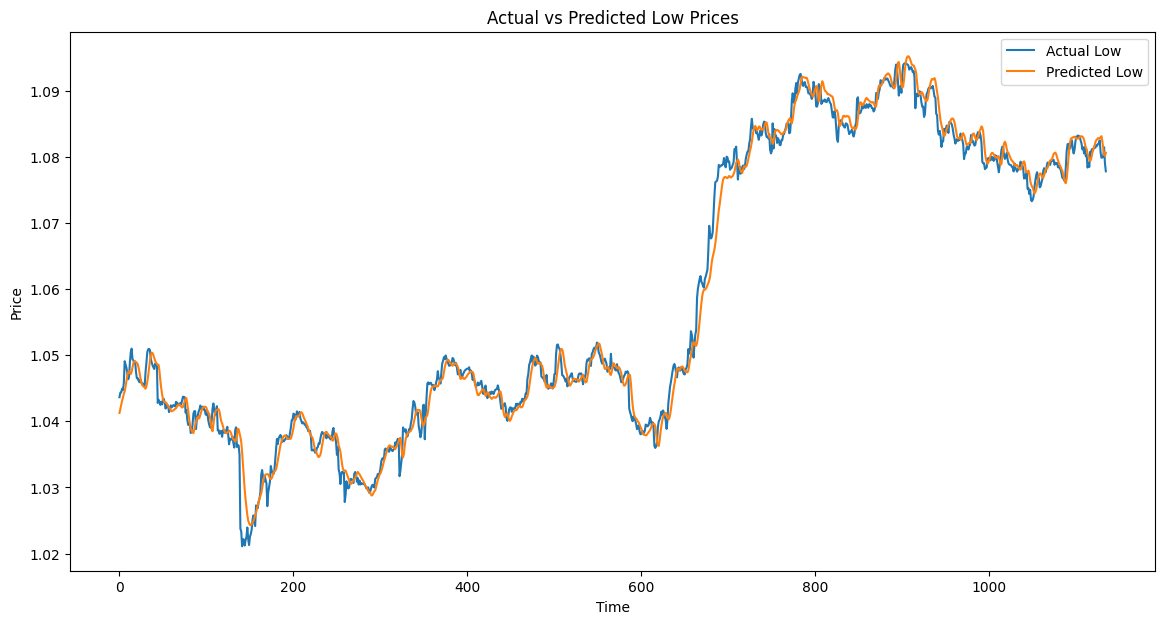

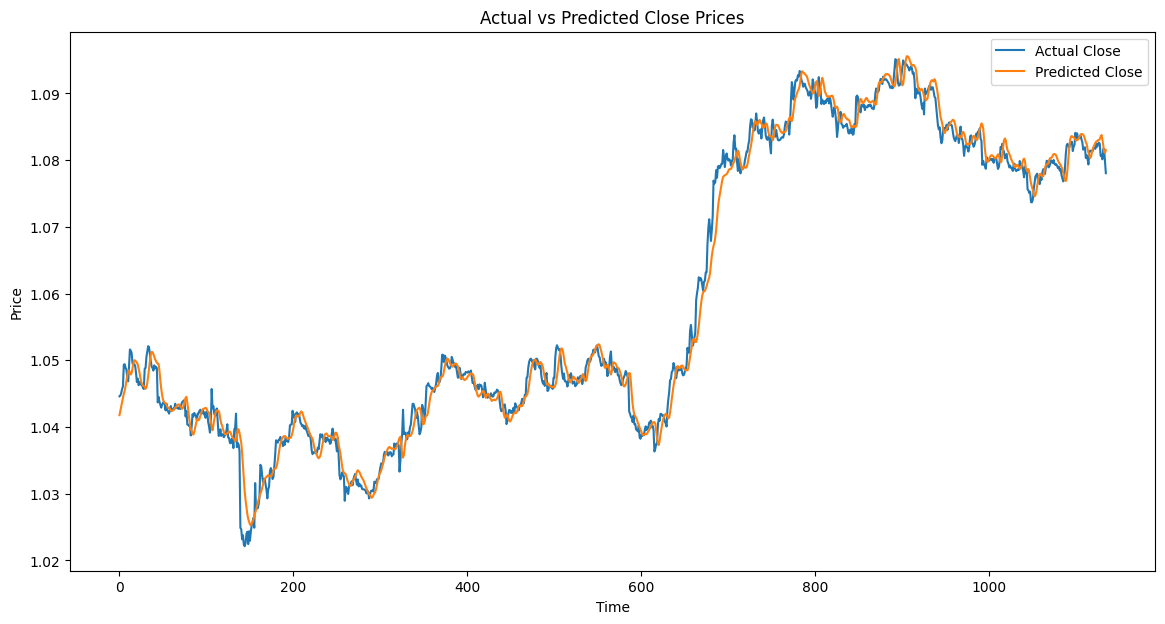

In [47]:
# Prédiction sur les données de test
predictions = history.model.predict(X_test)
predictions = dataset.target_scaler.inverse_transform(predictions)  # Inverser la normalisation

# Comparaison des prédictions avec les vraies valeurs
y_test_actual = dataset.target_scaler.inverse_transform(y_test)

# plot actual vs prediction for each feature
features = ['High', 'Low', 'Close']
for i, feature in enumerate(features):
    plt.figure(figsize=(14, 7))
    plt.plot(y_test_actual[:, i], label=f'Actual {feature}')
    plt.plot(predictions[:, i], label=f'Predicted {feature}')
    plt.title(f'Actual vs Predicted {feature} Prices')
    plt.xlabel('Time')
    plt.ylabel('Price')
    plt.legend()
    plt.show()


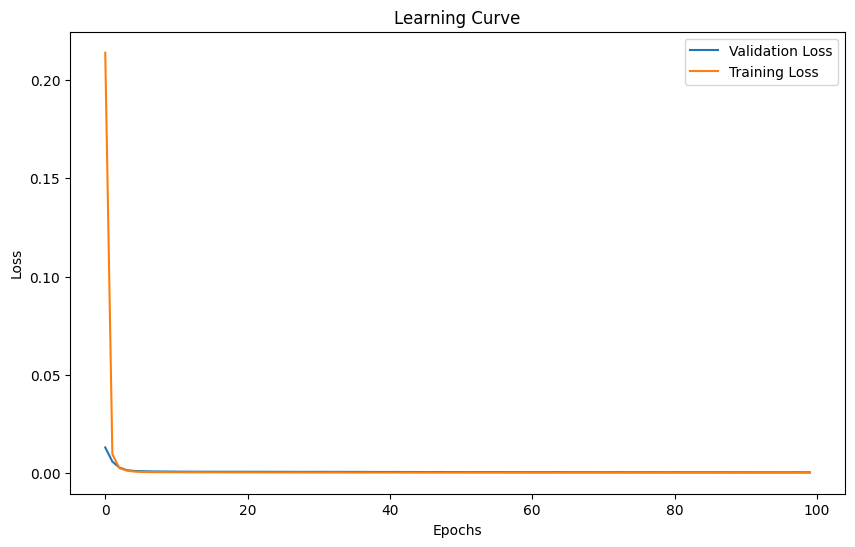

In [48]:
# Plotting the learning curve
plt.figure(figsize=(10, 6))
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['loss'], label='Training Loss')
plt.title('Learning Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Metriques d'évaluation

In [49]:
# Calculate Mean Squared Error
mse = mean_squared_error(y_test_actual, predictions)
print(f'Mean Squared Error: {mse}')

# Calculate Mean Absolute Error
mae = mean_absolute_error(y_test_actual, predictions)
print(f'Mean Absolute Error: {mae}')

# Calculate RMSE
rmse = np.sqrt(mse)
print(f'Root Mean Squared Error: {rmse}')

# R2
print('RSquared : ', '{:.2%}'.format(r2_score(y_test_actual, predictions)))

Mean Squared Error: 4.364885465432951e-06
Mean Absolute Error: 0.0014606509477388477
Root Mean Squared Error: 0.002089230831055523
RSquared :  99.05%


## Sauvegarde du model

In [50]:
history.model.save('../../models/test/best_model_EURUSD_candle.keras')
print('Model saved!!')

Model saved!!


In [42]:
# ts.to_csv('../../notebooks/inference/datasets/eur_usd_2024_03_2025.csv', index=True)